In [91]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from rebayes import base
from typing import Callable
from rebayes.low_rank_filter import lofi
from jax.flatten_util import ravel_pytree

from rebayes.utils.rotating_mnist_data import load_rotated_mnist

%config InlineBackend.figure_format = "retina"

In [179]:
import numpy as np
from rebayes.utils.utils import tree_to_cpu, get_subtree

In [13]:
class MLP(nn.Module):
    n_out: int = 1
    n_hidden: int = 100
    activation: Callable = nn.elu

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x


def load_data(sort_by_angle: bool = True):
    data = load_rotated_mnist(target_digit=2, sort_by_angle=sort_by_angle)
    train, test = data
    X_train, y_train = train
    X_test, y_test = test

    ymean, ystd = y_train.mean().item(), y_train.std().item()

    y_train = (y_train - ymean) / ystd
    y_test = (y_test - ymean) / ystd

    dataset = {
        "train": (X_train, y_train),
        "test": (X_test, y_test),
    }

    res = {
        "dataset": dataset,
        "ymean": ymean,
        "ystd": ystd,
    }

    return res

In [14]:
data = load_data(sort_by_angle=True)

In [25]:
_, dim_in = data["dataset"]["train"][0].shape

In [56]:
def make_bnn_flax(dim_in, nhidden=50):
    key = jax.random.PRNGKey(314)
    dim_out = 1
    model = MLP(dim_out, nhidden)
    params = model.init(key, jnp.ones((1, dim_in)))
    flat_params, recfn = ravel_pytree(params)
    n_params = len(flat_params)
    return model, params, flat_params, recfn

def apply_fn_flat(flat_params, x, model, recfn):
    return model.apply(recfn(flat_params), x)


model, dnn_params, flat_params, recfn = make_bnn_flax(dim_in)

def apply_fn_flat(flat_params, x, model, recfn):
    return model.apply(recfn(flat_params), x)

In [82]:
def callback(bel, pred_obs, t, X, y, bel_pred, apply_fn, ymean, ystd, **kwargs):    
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    # eval on all tasks test set
    yhat_test = apply_fn(bel.mean, X_test).squeeze()
    
    # Compute errors
    y_test = y_test * ystd + ymean
    yhat_test = yhat_test.ravel() * ystd + ymean
    
    y_next = y.ravel() * ystd + ymean
    yhat_next = pred_obs.ravel() * ystd + ymean
    
    err_test = jnp.power(y_test - yhat_test, 2).mean()
    err = jnp.power(y_next - yhat_next, 2).mean()
    
    err_test = jnp.sqrt(err_test)
    err = jnp.sqrt(err)
    
    res = {
        "test": err_test,
        "osa-error": err,
    }
    return res

In [314]:
ssm_params = base.RebayesParams(
        initial_mean=flat_params,
        initial_covariance=0.01, # 0.06
        dynamics_weights=1,
        dynamics_covariance=1e-2,#1e-7,
        emission_mean_function=partial(apply_fn_flat, model=model, recfn=recfn),
        emission_cov_function = lambda w,x: 0.02,
        adaptive_emission_cov=False,
        dynamics_covariance_inflation_factor=0.#0.1#0.001,
)

mem = 10
lofi_params = lofi.LoFiParams(memory_size=mem, steady_state=False, inflation="hybrid")

In [315]:
data.keys()

dict_keys(['dataset', 'ymean', 'ystd'])

In [316]:
X_train, Y_train = data["dataset"]["train"]
X_test, y_test = data["dataset"]["test"]

In [317]:
agent = lofi.RebayesLoFiDiagonal(ssm_params, lofi_params)

callback_part = partial(callback,
                        apply_fn=agent.params.emission_mean_function,
                        ymean=data["ymean"], ystd=data["ystd"],
                        X_test=X_test, y_test=y_test)

bel, outputs = agent.scan(X_train, Y_train, progress_bar=True, callback=callback_part)
bel = jax.block_until_ready(bel)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [318]:
outputs = tree_to_cpu(outputs)

In [338]:
ksize = 20
kernel = np.ones(ksize) / ksize

osa_smooth = np.convolve(outputs["osa-error"], kernel, mode="same")

In [339]:
ysort = Y_train * data["ystd"] + data["ymean"]

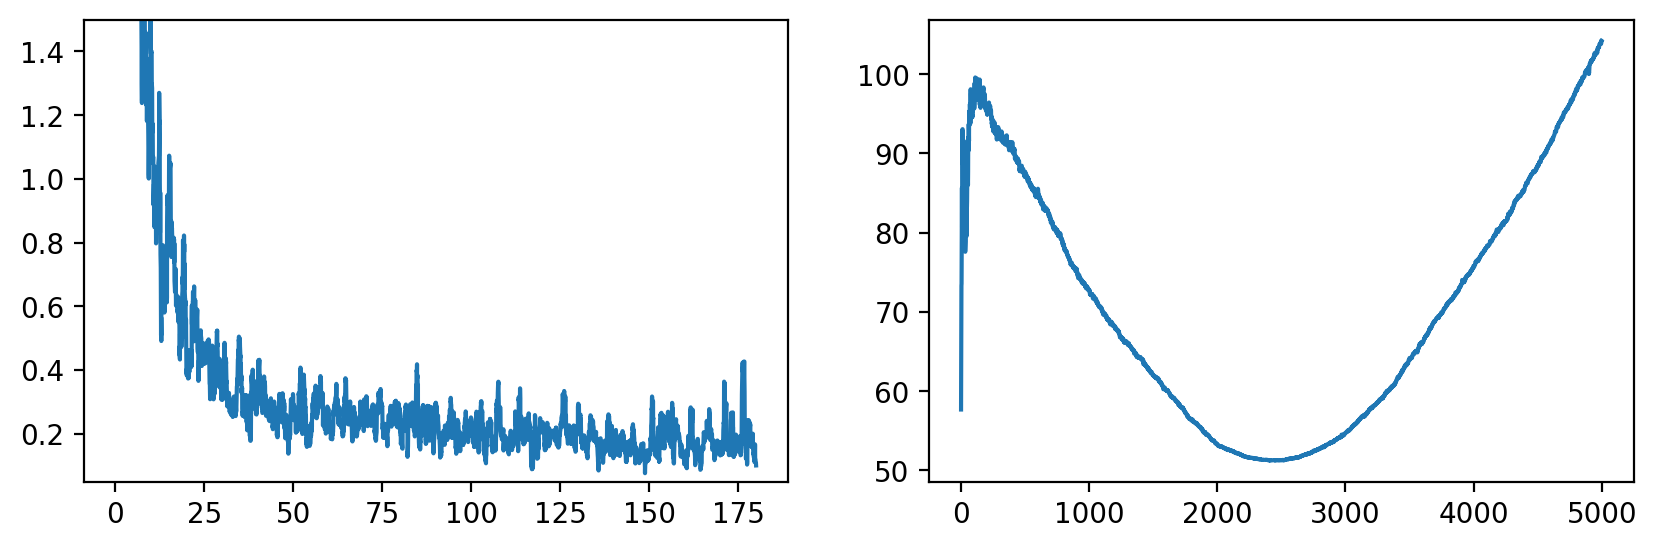

In [340]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(ysort, osa_smooth)
ax[0].set_ylim(0.05, 1.5)
ax[1].plot(outputs["test"])

In [411]:
@partial(jax.pmap, in_axes=(None, 0))
@partial(jax.vmap, in_axes=(0, None))
def eval_run(dcov, inflation):
    ssm_params = base.RebayesParams(
        initial_mean=flat_params,
        initial_covariance=0.01, # 0.06
        dynamics_weights=1,
        dynamics_covariance=dcov,
        emission_mean_function=partial(apply_fn_flat, model=model, recfn=recfn),
        emission_cov_function = lambda w,x: 0.02,
        adaptive_emission_cov=False,
        dynamics_covariance_inflation_factor=inflation
    )
    
    lofi_params = lofi.LoFiParams(memory_size=mem, steady_state=False, inflation="hybrid")
    agent = lofi.RebayesLoFiDiagonal(ssm_params, lofi_params)
    bel, outputs = agent.scan(X_train, Y_train, progress_bar=False, callback=callback_part)
    
    outputs["inflation"] = inflation
    outputs["dynamics_cov"] = dcov
    
    return outputs

In [412]:
inflation_vals = jnp.array([0.0, 0.1, 0.01, 0.001])
dynamics_cov_vals = jnp.array([0.0, 1e-1, 1e-2, 1e-3, 1e-4])

In [413]:
%%time
outputs = eval_run(dynamics_cov_vals, inflation_vals)
outputs = jax.block_until_ready(outputs)
outputs = tree_to_cpu(outputs)

CPU times: user 22.5 s, sys: 939 ms, total: 23.5 s
Wall time: 20.8 s


In [425]:
outputs["osa-error"].reshape(-1, 1).shape

(100000, 1)

In [426]:
ksize = 40
kernel = np.ones(ksize) / ksize

Text(0.5, 1.0, 'OSA—no inflation')

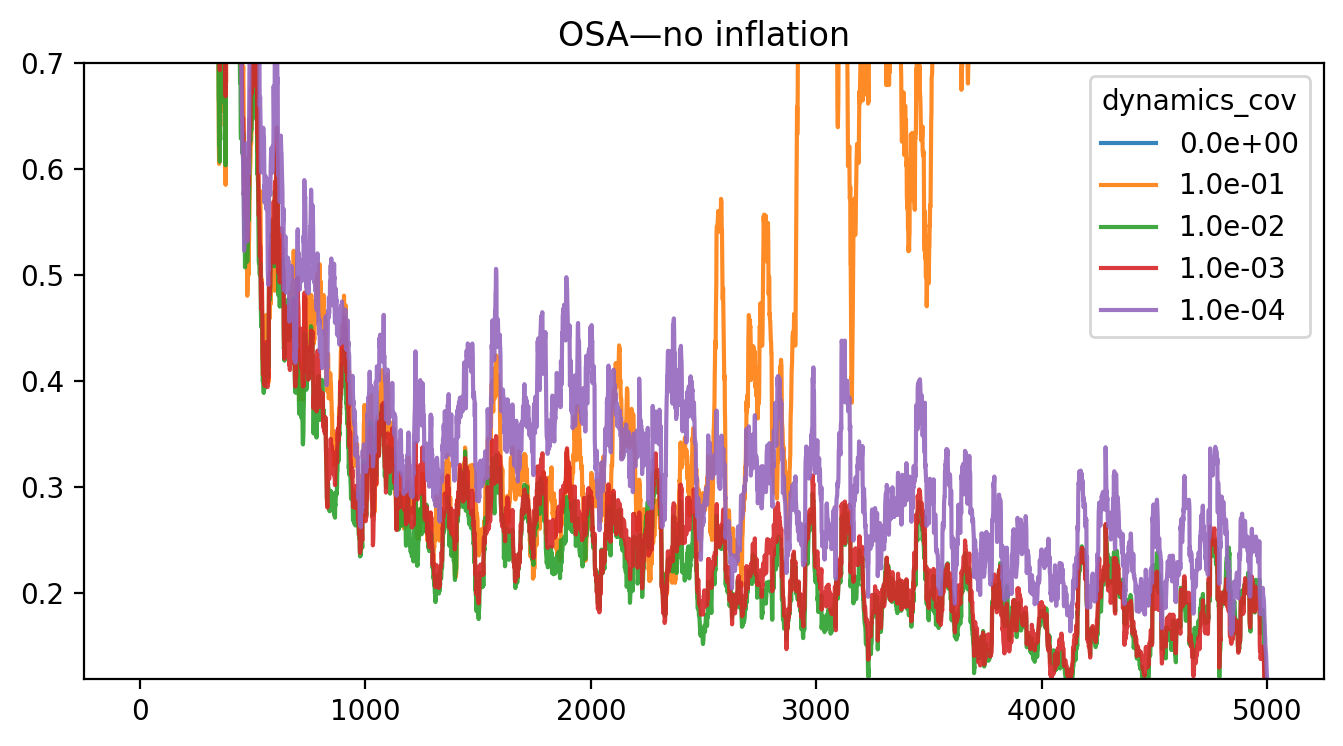

In [453]:
osa_array = outputs["osa-error"][0, ...]

fig, ax = plt.subplots(figsize=(8, 4))
for dcov, osa in zip(dynamics_cov_vals, osa_array):
    osa_smooth = np.convolve(osa, kernel, mode="same")
    plt.plot(osa_smooth, label=format(dcov, ".1e"), alpha=0.9)
    
vmax = np.quantile(osa_smooth, 0.90)
vmin = np.quantile(osa_smooth, 0.00)
plt.ylim(vmin, vmax)
plt.legend(title="dynamics_cov")
plt.title("OSA—no inflation")

Text(0.5, 1.0, 'OSA—no dynamics cov')

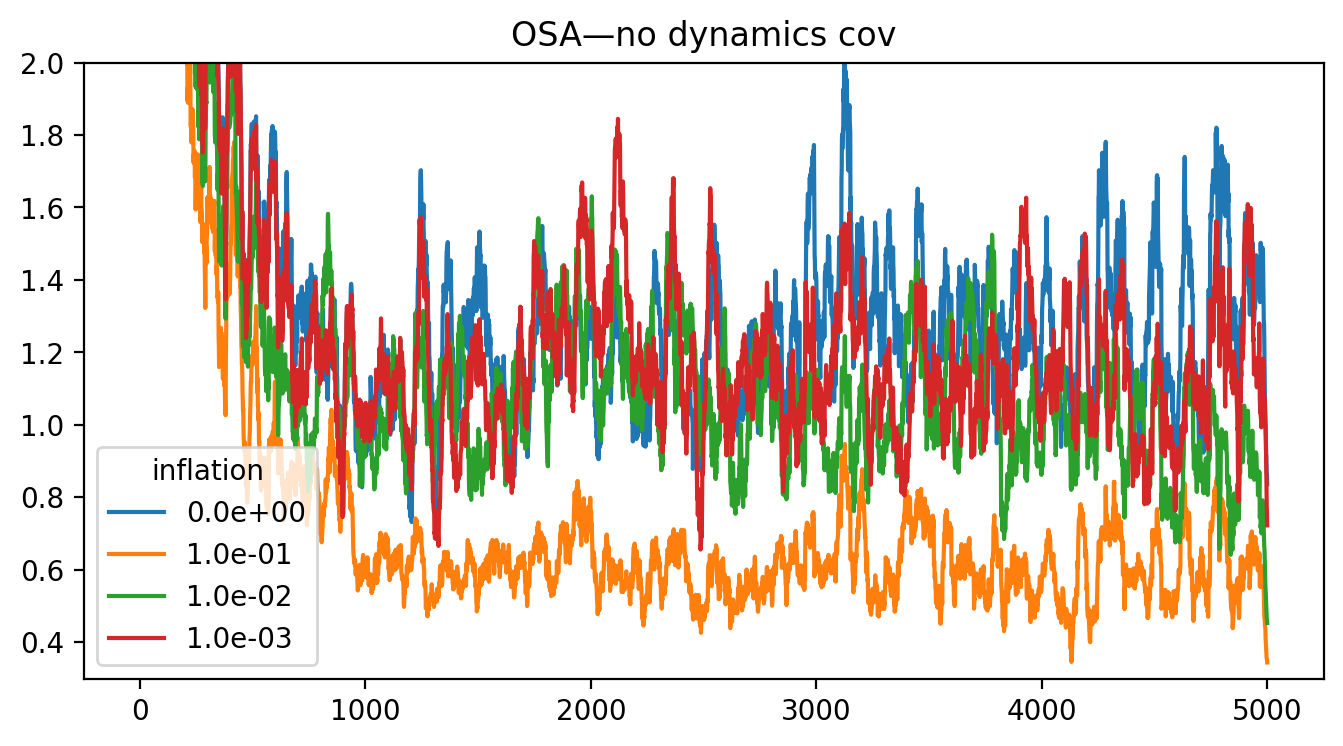

In [455]:
osa_array = outputs["osa-error"][:, 0, ...]

fig, ax = plt.subplots(figsize=(8, 4))
for dcov, osa in zip(inflation_vals, osa_array):
    osa_smooth = np.convolve(osa, kernel, mode="same")
    plt.plot(osa_smooth, label=format(dcov, ".1e"))


vmin, vmax = 0.3, 2.0
plt.ylim(vmin, vmax)
plt.legend(title="inflation")
plt.title("OSA—no dynamics cov")